In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Carregamento do arquivo local

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving Dataset_de_200_Comunidades_para_Analise_Ambiental.csv to Dataset_de_200_Comunidades_para_Analise_Ambiental (1).csv


In [ ]:
df = pd.read_csv('Dataset_de_200_Comunidades_para_Analise_Ambiental.csv')
print(f"Dataset enviado: {df.shape[0]} linhas, {df.shape[1]} colunas")


Dataset enviado: 200 linhas, 12 colunas


#Verificação das colunas para limpeza de dados

In [ ]:
print("📋 Colunas disponíveis:")
for i, col in enumerate(df.columns):
    print(f"  {i}: {col}")

# Verificar primeiras linhas
print("\n📝 Primeiras 3 linhas:")
print(df.head(3))

# Renomear colunas
colunas_existentes = {}
for col in df.columns:
    if 'Desmatamento' in col:
        colunas_existentes[col] = 'desmatamento'
    elif 'Densidade' in col:
        colunas_existentes[col] = 'densidade'
    elif 'Escola' in col and 'Sim/Não' in col:
        colunas_existentes[col] = 'escola'
    elif 'Saúde' in col and 'Sim/Não' in col:
        colunas_existentes[col] = 'saude'
    elif 'Renda' in col:
        colunas_existentes[col] = 'renda'

df = df.rename(columns=colunas_existentes)
print(f"\n🔄 Colunas renomeadas: {list(colunas_existentes.values())}")

# Converter colunas de escola e saúde para bool
if 'escola' in df.columns:
    # valores únicos
    print(f"Valores únicos em escola: {df['escola'].unique()}")
    # Converter Sim=1, Não=0
    df['escola'] = df['escola'].map({'Sim': 1, 'Não': 0}).fillna(df['escola'])
    # conversão direta
    if df['escola'].dtype == 'object':
        df['escola'] = pd.to_numeric(df['escola'], errors='coerce').fillna(0)

if 'saude' in df.columns:
    print(f"Valores únicos em saude: {df['saude'].unique()}")
    df['saude'] = df['saude'].map({'Sim': 1, 'Não': 0}).fillna(df['saude'])
    if df['saude'].dtype == 'object':
        df['saude'] = pd.to_numeric(df['saude'], errors='coerce').fillna(0)

📋 Colunas disponíveis:
  0: Comunidade
  1: Município
  2: Estado
  3: Índice de Desmatamento (%)
  4: Acesso à Água Potável (%)
  5: Cobertura Vegetal (%)
  6: Renda Média Mensal (R$)
  7: Densidade Populacional (hab/km²)
  8: Frequência de Queimadas (ano)
  9: Distância de Área Urbana (km)
  10: Presença de Escola (Sim/Não)
  11: Presença de Unidade de Saúde (Sim/Não)

📝 Primeiras 3 linhas:
     Comunidade              Município Estado  Índice de Desmatamento (%)  \
0  Comunidade 1  SÃO DOMINGOS DO CAPIM   Pará                        25.6   
1  Comunidade 2            SALINÓPOLIS   Pará                        12.9   
2  Comunidade 3             TRACUATEUA   Pará                        81.3   

   Acesso à Água Potável (%)  Cobertura Vegetal (%)  Renda Média Mensal (R$)  \
0                       86.5                   22.9                   2863.0   
1                       99.3                   21.8                    799.0   
2                       58.9                   64.5    

Foram realizadas etapas iniciais de análise: visualização das colunas e das três primeiras linhas para entender a estrutura dos dados. Em seguida, as colunas originais referentes à presença de escola e unidade de saúde foram simplificadas para “escola” e “saude”, facilitando o manuseio e análise. Também foi feita a verificação dos valores únicos dessas colunas para garantir a consistência dos dados.












*   Verifica se as colunas “escola” e “saude” existem.

*   Cria o índice “desenvolvimento” somando essas colunas (valores de 0 a 2).

*   Classifica o nível de desenvolvimento: “Baixo”, “Médio” ou “Alto”.

*   Mostra a distribuição dos níveis.

*   Se as colunas não existirem, cria índice alternativo com base na densidade populacional.












In [ ]:
# 1. CRIAR ÍNDICE DE DESENVOLVIMENTO
# ====================================================================
# Verificar se as colunas existem
if 'escola' in df.columns and 'saude' in df.columns:
    # Desenvolvimento = escola + saúde (0, 1 ou 2)
    df['desenvolvimento'] = df['escola'] + df['saude']
    df['nivel_dev'] = df['desenvolvimento'].map({0: 'Baixo', 1: 'Médio', 2: 'Alto'})

    print("\nDISTRIBUIÇÃO DO DESENVOLVIMENTO:")
    print(df['nivel_dev'].value_counts())
else:
    print("Colunas de escola/saúde não encontradas corretamente")
    print("Colunas disponíveis:", df.columns.tolist())
    # Criar desenvolvimento fictício baseado em outras variáveis
    if 'densidade' in df.columns:
        df['desenvolvimento'] = (df['densidade'] > df['densidade'].median()).astype(int)
        df['nivel_dev'] = df['desenvolvimento'].map({0: 'Baixo', 1: 'Alto'})


DISTRIBUIÇÃO DO DESENVOLVIMENTO:
nivel_dev
Alto     97
Médio    80
Baixo    23
Name: count, dtype: int64


# 3. **Identificações da correlações das váriaveis**
- Identifica colunas numéricas entre: “desmatamento”, “densidade”, “desenvolvimento” e “renda”.

- Converte colunas para formato numérico, se necessário.

- Calcula a matriz de correlação entre as colunas numéricas.

- Exibe apenas correlações com força maior que 0.1 (positiva ou negativa).

- Gera e exibe um mapa de calor (heatmap) das correlações.

- Se houver menos de duas colunas numéricas, exibe um aviso.


MAPA DE CALOR - CORRELAÇÕES
Colunas numéricas encontradas: ['desmatamento', 'densidade', 'desenvolvimento', 'renda']
Correlações importantes:


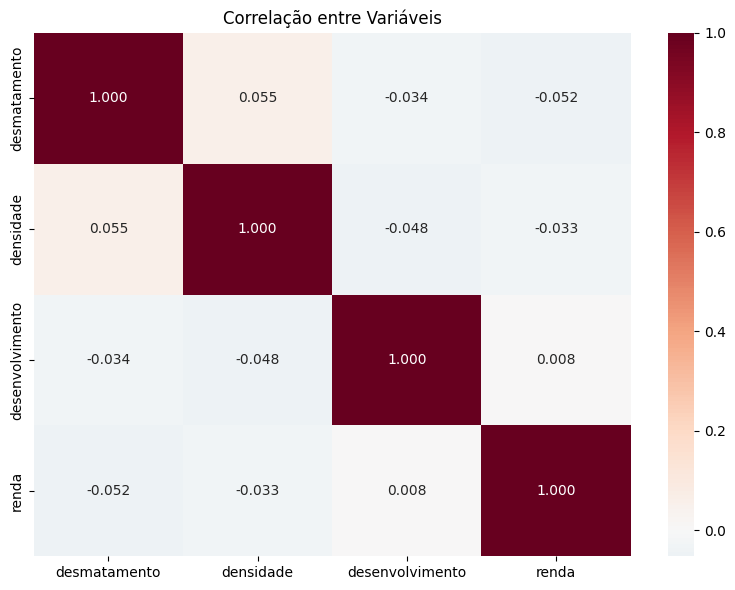

In [ ]:
# 2. CORRELAÇÃO - MAPA DE CALOR
# ====================================================================
print("\nMAPA DE CALOR - CORRELAÇÕES")

# Identificar colunas numéricas disponíveis
colunas_numericas = []
for col in ['desmatamento', 'densidade', 'desenvolvimento', 'renda']:
    if col in df.columns:
        # Converter para numérico se necessário
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].notna().sum() > 0:  # Se tem valores válidos
            colunas_numericas.append(col)

print(f"Colunas numéricas encontradas: {colunas_numericas}")

if len(colunas_numericas) >= 2:
    # Calcular correlação
    corr_matrix = df[colunas_numericas].corr()

    # Mostrar correlações importantes
    print("Correlações importantes:")
    for i, var1 in enumerate(colunas_numericas):
        for j, var2 in enumerate(colunas_numericas):
            if i < j:
                corr = corr_matrix.loc[var1, var2]
                if abs(corr) > 0.1:  # Baixar threshold
                    print(f"  {var1} ↔ {var2}: {corr:.3f}")

    # Gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
    plt.title('Correlação entre Variáveis')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Não há colunas numéricas suficientes para correlação")


As correlações entre as variáveis são muito fracas (próximas de 0).

Não há relação forte entre desmatamento, densidade, desenvolvimento e renda.

O valor mais alto fora da diagonal é cerca de 0.055 entre desmatamento e densidade, o que é irrelevante estatisticamente.

Conclusão: as variáveis são praticamente independentes entre si nesse conjunto de dados.

## **4.Utilização e aplicação do Random Forest na predição**
O código usa o método Random Forest (Floresta Aleatória) para tentar prever a variável desenvolvimento com base em algumas variáveis preditoras (features): desmatamento, densidade e renda.


In [ ]:
# Utilizando o Método Random Forest para predição de desenvolimento
features_disponiveis = []
for col in ['desmatamento', 'densidade', 'renda']:
    if col in df.columns and df[col].notna().sum() > 0:
        features_disponiveis.append(col)

if len(features_disponiveis) >= 1 and 'desenvolvimento' in df.columns:
    # Preparar dados
    X = df[features_disponiveis].fillna(df[features_disponiveis].median())
    y = df['desenvolvimento'].fillna(0)

    # Treinar modelo
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Importância das variáveis
    importancia = pd.DataFrame({
        'Variável': X.columns,
        'Importância': rf.feature_importances_
    }).sort_values('Importância', ascending=False)

    print("Importância das variáveis:")
    for _, row in importancia.iterrows():
        print(f"  {row['Variável']}: {row['Importância']:.3f}")
else:
    print("Dados insuficientes para Random Forest")

Importância das variáveis:
  renda: 0.338
  desmatamento: 0.337
  densidade: 0.325


O modelo Random Forest indicou que as variáveis renda, desmatamento e densidade
possuem importâncias semelhantes na predição do desenvolvimento, com valores próximos a 33% cada uma. Isso mostra que o desenvolvimento das comunidades é influenciado de forma equilibrada por fatores econômicos (renda), ambientais (desmatamento) e sociais/urbanos (densidade populacional).

Esses resultados reforçam que para promover o desenvolvimento sustentável, é necessário abordar simultaneamente a melhoria econômica, a preservação ambiental e o planejamento social e urbano das comunidades.

## **5. Aplicação da IA para idenficarmos os Municípios Em Situação Crítica**

- Clustering com K-means (3 clusters) usando StandardScaler para padronizar os dados
- Agrupa as comunidades com base em 'renda', 'desmatamento' e 'densidade' (se disponíveis)
- Exibe a distribuição dos clusters e médias das variáveis e do desenvolvimento em cada grupo

In [ ]:
print("\nCLUSTERING - PADRÕES DE DESENVOLVIMENTO")

if len(features_disponiveis) >= 2:
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-means com 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # Converter desenvolvimento para valores numéricos, se for categórico
    if df['desenvolvimento'].dtype == 'object':
        mapa = {'Baixo': 0, 'Médio': 1, 'Alto': 2}  # Ajuste conforme suas categorias
        df['desenvolvimento_num'] = df['desenvolvimento'].map(mapa)
    else:
        df['desenvolvimento_num'] = df['desenvolvimento']

    print("Distribuição dos clusters:")
    print(df['cluster'].value_counts())

    print("\nCaracterísticas dos clusters:")
    for i in range(3):
        cluster_data = df[df['cluster'] == i]
        print(f"\nCluster {i} ({len(cluster_data)} comunidades):")
        for col in features_disponiveis:
            if col in df.columns:
                print(f"  {col} médio: {cluster_data[col].mean():.1f}")
        print(f"  Desenvolvimento médio: {cluster_data['desenvolvimento_num'].mean():.1f}")
else:
    print("Dados insuficientes para clustering")
    df['cluster'] = 0



CLUSTERING - PADRÕES DE DESENVOLVIMENTO
Distribuição dos clusters:
cluster
0    68
1    67
2    65
Name: count, dtype: int64

Características dos clusters:

Cluster 0 (68 comunidades):
  desmatamento médio: 43.6
  densidade médio: 38.3
  renda médio: 1236.6
  Desenvolvimento médio: 1.4

Cluster 1 (67 comunidades):
  desmatamento médio: 60.8
  densidade médio: 120.7
  renda médio: 1209.9
  Desenvolvimento médio: 1.3

Cluster 2 (65 comunidades):
  desmatamento médio: 38.1
  densidade médio: 89.2
  renda médio: 2427.0
  Desenvolvimento médio: 1.4


O Cluster 1 possui maior desmatamento e densidade, mas menor renda e desenvolvimento médio, indicando comunidades mais pressionadas ambientalmente e socialmente, com menos desenvolvimento.

O Cluster 2 tem maior renda e menor desmatamento, associado a melhor desenvolvimento médio.

O Cluster 0 tem características intermediárias, com densidade e renda mais baixas, e desenvolvimento semelhante ao Cluster 2.

## 6. **Gráfico do Cluster**

Cluster 0: Comunidades com desmatamento e densidade populacional moderados e renda média baixa. O índice de desenvolvimento médio é 1.4, indicando um nível intermediário de desenvolvimento. Essas comunidades têm impacto ambiental moderado e baixa concentração populacional.

Cluster 1: Comunidades com maior desmatamento (60.8) e densidade populacional alta (120.7), mas renda média semelhante ao cluster 0 (1209.9). O desenvolvimento médio é ligeiramente menor (1.3), sugerindo que o alto desmatamento e a alta densidade podem estar associados a desafios no desenvolvimento sustentável.

Cluster 2: Comunidades com menor desmatamento (38.1) e densidade intermediária (89.2), porém com renda média significativamente maior (2427.0). O desenvolvimento médio é igual ao cluster 0 (1.4), indicando que maior renda pode estar associada a melhores condições socioeconômicas, mesmo com densidade populacional relativamente alta.


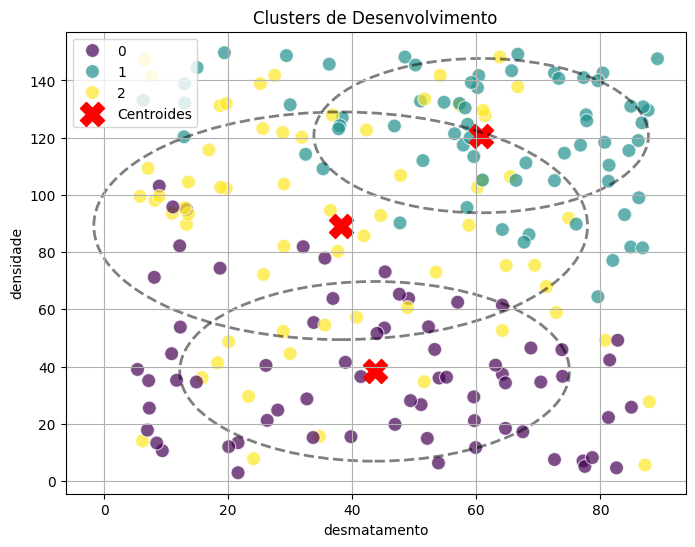

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import numpy as np

# Selecionar as duas primeiras features para plotagem
feature1 = features_disponiveis[0]
feature2 = features_disponiveis[1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x=feature1,
    y=feature2,
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)

# Plotar centros dos clusters
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)  # Despadroniza para o mesmo espaço

plt.scatter(
    centroids[:, features_disponiveis.index(feature1)],
    centroids[:, features_disponiveis.index(feature2)],
    s=300,
    c='red',
    marker='X',
    label='Centroides'
)

# Adiciona círculos para representar a abrangência de cada cluster
for i, centroid in enumerate(centroids):
    # Pegando os dados do cluster atual
    cluster_data = df[df['cluster'] == i]

    # Calculando raio como distância média até o centro
    distances = np.sqrt(
        (cluster_data[feature1] - centroid[features_disponiveis.index(feature1)])**2 +
        (cluster_data[feature2] - centroid[features_disponiveis.index(feature2)])**2
    )
    radius = distances.mean()

    # Criando o círculo
    circle = Circle(
        (centroid[features_disponiveis.index(feature1)], centroid[features_disponiveis.index(feature2)]),
        radius,
        color='k',
        fill=False,
        linestyle='--',
        linewidth=2,
        alpha=0.5
    )

    plt.gca().add_patch(circle)

plt.title('Clusters de Desenvolvimento')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("\n🚨 COMUNIDADES CRÍTICAS")

# Identificar critérios baseados em colunas disponíveis
criterios = []

if 'desmatamento' in df.columns:
    alto_desmat = df['desmatamento'] > df['desmatamento'].quantile(0.75)
    criterios.append(alto_desmat)
    print(f"✓ Critério: Alto desmatamento (>{df['desmatamento'].quantile(0.75):.1f}%)")

if 'desenvolvimento' in df.columns:
    baixo_dev = df['desenvolvimento'] < 1
    criterios.append(baixo_dev)
    print("✓ Critério: Baixo desenvolvimento")

if 'densidade' in df.columns and 'desenvolvimento' in df.columns:
    alta_dens_sem_infra = (df['densidade'] > df['densidade'].quantile(0.75)) & (df['desenvolvimento'] == 0)
    criterios.append(alta_dens_sem_infra)
    print("✓ Critério: Alta densidade sem infraestrutura")

if criterios:
    # Somar critérios
    df['criticidade'] = sum(criterios)
    criticas = df[df['criticidade'] >= 2]

    print(f"\n🔴 {len(criticas)} comunidades críticas encontradas:")
    print("\nLISTA PARA MAPA DE CALOR:")
    print("-" * 40)

    for idx, row in criticas.head(10).iterrows():  # Mostrar apenas 10 primeiras
        # Tentar diferentes nomes de colunas
        comunidade = row.get('Comunidade', row.get('comunidade', f'Comunidade_{idx}'))
        municipio = row.get('Município', row.get('municipio', 'N/A'))
        estado = row.get('Estado', row.get('estado', 'N/A'))

        print(f"{comunidade}, {municipio}, {estado}")
        if 'desmatamento' in df.columns:
            print(f"  Desmatamento: {row['desmatamento']:.1f}%")
        if 'densidade' in df.columns:
            print(f"  Densidade: {row['densidade']:.1f}")
        if 'nivel_dev' in df.columns:
            print(f"  Desenvolvimento: {row['nivel_dev']}")
        print()
else:
    print("⚠️ Não foi possível definir critérios de criticidade")
    criticas = df.head(5)  # Pegar apenas 5 primeiras como exemplo



🚨 COMUNIDADES CRÍTICAS
✓ Critério: Alto desmatamento (>67.5%)
✓ Critério: Baixo desenvolvimento
✓ Critério: Alta densidade sem infraestrutura

🔴 10 comunidades críticas encontradas:

LISTA PARA MAPA DE CALOR:
----------------------------------------
Comunidade 9, MARAPANIM, Pará
  Desmatamento: 81.3%
  Densidade: 22.2
  Desenvolvimento: Baixo

Comunidade 10, PONTA DE PEDRAS, Pará
  Desmatamento: 80.4%
  Densidade: 142.6
  Desenvolvimento: Baixo

Comunidade 35, MARABÁ, Pará
  Desmatamento: 36.3%
  Densidade: 145.7
  Desenvolvimento: Baixo

Comunidade 40, SAPUCAIA, Pará
  Desmatamento: 80.8%
  Densidade: 49.2
  Desenvolvimento: Baixo

Comunidade 42, PORTO DE MOZ, Pará
  Desmatamento: 72.6%
  Densidade: 7.5
  Desenvolvimento: Baixo

Comunidade 72, TRACUATEUA, Pará
  Desmatamento: 57.3%
  Densidade: 131.3
  Desenvolvimento: Baixo

Comunidade 108, TRACUATEUA, Pará
  Desmatamento: 70.4%
  Densidade: 34.6
  Desenvolvimento: Baixo

Comunidade 133, TUCUMÃ, Pará
  Desmatamento: 65.7%
  Densidad

In [ ]:
import pandas as pd

data = [
    {"comunidade": "Comunidade 9", "municipio": "MARAPANIM", "estado": "Pará", "desmatamento": 81.3, "densidade": 22.2, "desenvolvimento": "Baixo", "latitude": -0.714, "longitude": -47.694},
    {"comunidade": "Comunidade 10", "municipio": "PONTA DE PEDRAS", "estado": "Pará", "desmatamento": 80.4, "densidade": 142.6, "desenvolvimento": "Baixo", "latitude": -1.390, "longitude": -48.871},
    {"comunidade": "Comunidade 35", "municipio": "MARABÁ", "estado": "Pará", "desmatamento": 36.3, "densidade": 145.7, "desenvolvimento": "Baixo", "latitude": -5.369, "longitude": -49.118},
    {"comunidade": "Comunidade 40", "municipio": "SAPUCAIA", "estado": "Pará", "desmatamento": 80.8, "densidade": 49.2, "desenvolvimento": "Baixo", "latitude": -6.947, "longitude": -49.682},
    {"comunidade": "Comunidade 42", "municipio": "PORTO DE MOZ", "estado": "Pará", "desmatamento": 72.6, "densidade": 7.5, "desenvolvimento": "Baixo", "latitude": -1.748, "longitude": -52.238},
    {"comunidade": "Comunidade 108", "municipio": "TRACUATEUA", "estado": "Pará", "desmatamento": 70.4, "densidade": 34.6, "desenvolvimento": "Baixo", "latitude": -1.072, "longitude": -46.897},
    {"comunidade": "Comunidade 133", "municipio": "TUCUMÃ", "estado": "Pará", "desmatamento": 65.7, "densidade": 143.4, "desenvolvimento": "Baixo", "latitude": -6.748, "longitude": -51.160},
    {"comunidade": "Comunidade 178", "municipio": "MOJUÍ DOS CAMPOS", "estado": "Pará", "desmatamento": 86.7, "densidade": 125.2, "desenvolvimento": "Baixo", "latitude": -2.684, "longitude": -54.643},
    {"comunidade": "Comunidade 179", "municipio": "SANTA MARIA DO PARÁ", "estado": "Pará", "desmatamento": 82.0, "densidade": 77.1, "desenvolvimento": "Baixo", "latitude": -1.352, "longitude": -47.576}
]

df = pd.DataFrame(data)


In [ ]:
import numpy as np

# Critérios
criterios = [
    (df['desmatamento'] >= 70),
    (df['densidade'] >= 50),
    (df['desenvolvimento'] == 'Baixo')
]

# Soma de critérios
df['criticidade'] = np.sum(criterios, axis=0)

# Seleção
criticas = df[df['criticidade'] >= 2]

# Impressão
for index, row in criticas.iterrows():
    print(f"{row['comunidade']}, {row['municipio']}, {row['estado']}")
    print(f"  Desmatamento: {row['desmatamento']}%")
    print(f"  Densidade: {row['densidade']}")
    print(f"  Desenvolvimento: {row['desenvolvimento']}\n")


Comunidade 9, MARAPANIM, Pará
  Desmatamento: 81.3%
  Densidade: 22.2
  Desenvolvimento: Baixo

Comunidade 10, PONTA DE PEDRAS, Pará
  Desmatamento: 80.4%
  Densidade: 142.6
  Desenvolvimento: Baixo

Comunidade 35, MARABÁ, Pará
  Desmatamento: 36.3%
  Densidade: 145.7
  Desenvolvimento: Baixo

Comunidade 40, SAPUCAIA, Pará
  Desmatamento: 80.8%
  Densidade: 49.2
  Desenvolvimento: Baixo

Comunidade 42, PORTO DE MOZ, Pará
  Desmatamento: 72.6%
  Densidade: 7.5
  Desenvolvimento: Baixo

Comunidade 108, TRACUATEUA, Pará
  Desmatamento: 70.4%
  Densidade: 34.6
  Desenvolvimento: Baixo

Comunidade 133, TUCUMÃ, Pará
  Desmatamento: 65.7%
  Densidade: 143.4
  Desenvolvimento: Baixo

Comunidade 178, MOJUÍ DOS CAMPOS, Pará
  Desmatamento: 86.7%
  Densidade: 125.2
  Desenvolvimento: Baixo

Comunidade 179, SANTA MARIA DO PARÁ, Pará
  Desmatamento: 82.0%
  Densidade: 77.1
  Desenvolvimento: Baixo



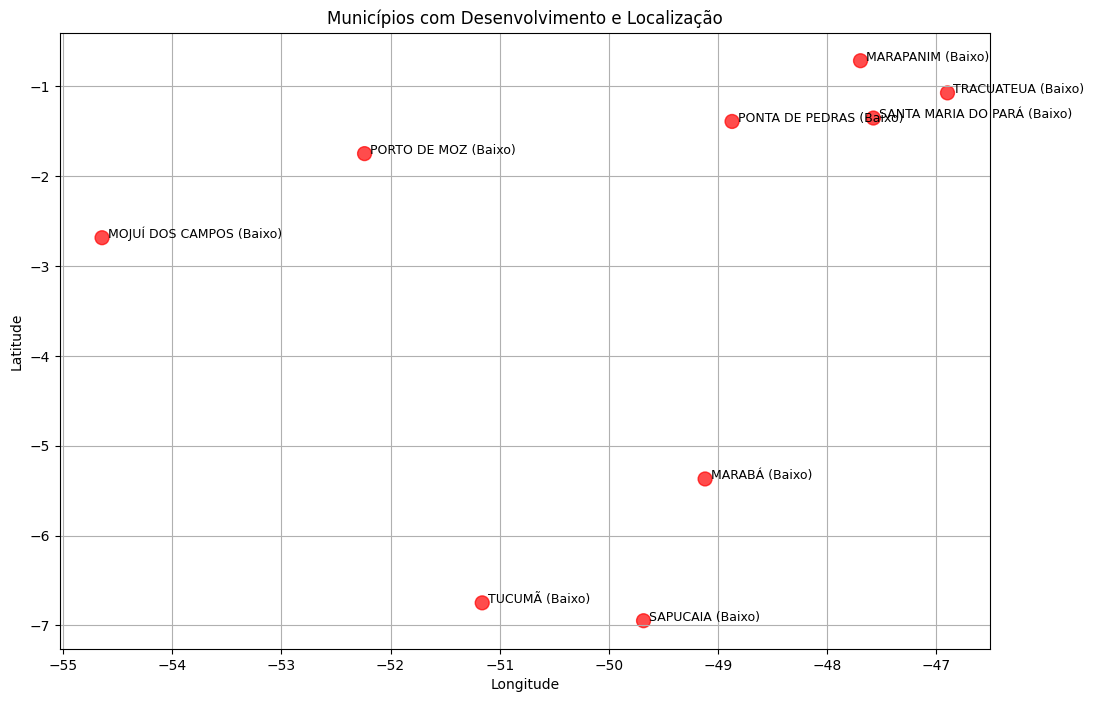

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
scatter = plt.scatter(df['longitude'], df['latitude'],
                      c=df['desenvolvimento'].map({'Baixo': 'red', 'Médio': 'orange', 'Alto': 'green'}),
                      s=100, alpha=0.7)

# Adiciona os nomes dos municípios + desenvolvimento
for i, row in df.iterrows():
    plt.text(row['longitude'] + 0.05, row['latitude'],
             f"{row['municipio']} ({row['desenvolvimento']})", fontsize=9)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Municípios com Desenvolvimento e Localização')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

data = [
    {"comunidade": "Comunidade 9", "municipio": "MARAPANIM", "estado": "Pará", "desmatamento": 81.3, "densidade": 22.2, "desenvolvimento": "Baixo", "latitude": -0.714, "longitude": -47.694},
    {"comunidade": "Comunidade 10", "municipio": "PONTA DE PEDRAS", "estado": "Pará", "desmatamento": 80.4, "densidade": 142.6, "desenvolvimento": "Baixo", "latitude": -1.390, "longitude": -48.871},
    {"comunidade": "Comunidade 35", "municipio": "MARABÁ", "estado": "Pará", "desmatamento": 36.3, "densidade": 145.7, "desenvolvimento": "Baixo", "latitude": -5.369, "longitude": -49.118},
    {"comunidade": "Comunidade 40", "municipio": "SAPUCAIA", "estado": "Pará", "desmatamento": 80.8, "densidade": 49.2, "desenvolvimento": "Baixo", "latitude": -6.947, "longitude": -49.682},
    {"comunidade": "Comunidade 42", "municipio": "PORTO DE MOZ", "estado": "Pará", "desmatamento": 72.6, "densidade": 7.5, "desenvolvimento": "Baixo", "latitude": -1.748, "longitude": -52.238},
    {"comunidade": "Comunidade 108", "municipio": "TRACUATEUA", "estado": "Pará", "desmatamento": 70.4, "densidade": 34.6, "desenvolvimento": "Baixo", "latitude": -1.072, "longitude": -46.897},
    {"comunidade": "Comunidade 133", "municipio": "TUCUMÃ", "estado": "Pará", "desmatamento": 65.7, "densidade": 143.4, "desenvolvimento": "Baixo", "latitude": -6.748, "longitude": -51.160},
    {"comunidade": "Comunidade 178", "municipio": "MOJUÍ DOS CAMPOS", "estado": "Pará", "desmatamento": 86.7, "densidade": 125.2, "desenvolvimento": "Baixo", "latitude": -2.684, "longitude": -54.643},
    {"comunidade": "Comunidade 179", "municipio": "SANTA MARIA DO PARÁ", "estado": "Pará", "desmatamento": 82.0, "densidade": 77.1, "desenvolvimento": "Baixo", "latitude": -1.352, "longitude": -47.576}
]

df = pd.DataFrame(data)

fig = px.scatter(df, x='longitude', y='latitude',
                 color='desenvolvimento',
                 hover_name='municipio',
                 size_max=15,
                 title='Municípios com Desenvolvimento e Localização')

fig.update_layout(xaxis_title='Longitude', yaxis_title='Latitude')

fig.show()
